# CoraGNN Benchmarking

*This notebook benchmarks three Graph Neural Network architectures (GCN, GraphSAGE, GAT) plus a logistic-regression baseline on the Cora citation dataset. We compare test accuracy, runtime, memory usage, and analyze node embeddings via t-SNE, confusion matrices, cluster purity, and sample misclassifications.*

## Environment & Configuration

Load versions and experiment parameters from YAML so everything is reproducible.

In [1]:
import os
from pathlib import Path

cwd = Path().parent.resolve()
cwd = cwd.parent.resolve()
os.chdir(cwd)
print(f"Current working directory: {cwd}")

Current working directory: /Users/AnshulSrivastava/Desktop/CoraGNN-Benchmark


In [2]:
import sys, torch, yaml
from torch_geometric import __version__ as pyg_v
import sklearn, mlflow

# Print core versions
print(f"Python {sys.version.split()[0]} | Torch {torch.__version__} | PyG {pyg_v} | sklearn {sklearn.__version__}")

# Load YAML config
with open("configs/config.yaml") as f:
    cfg = yaml.safe_load(f)
print("Config:", cfg)

Python 3.11.13 | Torch 2.7.1 | PyG 2.6.1 | sklearn 1.7.0
Config: {'data': {'root_dir': 'data', 'name': 'Cora'}, 'model': {'type': 'gat', 'hidden_size': 16, 'dropout': 0.5, 'gat_heads': 8}, 'training': {'lr': 0.01, 'weight_decay': 0.0005, 'epochs': 200, 'seed': 42, 'ckpt_path_template': 'checkpoints/{model}.pt', 'interval': 10}, 'mlflow': {'experiment': 'Cora-GNN'}}


## Data Loading & Preprocessing

We use PyG’s Planetoid loader with the standard split (140/500/1000) and feature normalization.

In [3]:
from src.data_loader import load_cora
import numpy as np

data = load_cora(cfg["data"]["root_dir"])
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")

# Class distribution
labels = data.y.cpu().numpy()
unique, counts = np.unique(labels, return_counts=True)
print("Class counts:", dict(zip(unique, counts)))

Nodes: 2708, Edges: 10556
Class counts: {np.int64(0): np.int64(351), np.int64(1): np.int64(217), np.int64(2): np.int64(418), np.int64(3): np.int64(818), np.int64(4): np.int64(426), np.int64(5): np.int64(298), np.int64(6): np.int64(180)}


## Baseline: Logistic Regression

A simple linear model on raw node features provides a performance floor.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X, y = data.x.numpy(), data.y.numpy()
masks = {"Val": data.val_mask, "Test": data.test_mask}

clf = LogisticRegression(max_iter=2000).fit(X[data.train_mask], y[data.train_mask])
for split, mask in masks.items():
    pred = clf.predict(X[mask])
    print(f"{split} Acc: {accuracy_score(y[mask], pred):.4f} | F1: {f1_score(y[mask], pred, average='macro'):.4f}")

Val Acc: 0.5600 | F1: 0.5386
Test Acc: 0.5740 | F1: 0.5535


## GNN Architectures

- **GCN**: Spectral graph convolution, two layers, transductive.  
- **GraphSAGE**: Inductive neighbor‐aggregator framework (mean pooling).  
- **GAT**: Self‐attention on edges with multi‐head pooling.

## Comparative Results

Test accuracy, average epoch time, and peak memory for each model.


In [5]:
import pandas as pd

# Replace the numbers below with your logged results from MLflow
results = pd.DataFrame([
    {"Model": "Baseline",   "Test Acc": 0.5740, "Epoch Time (s)": None,  "Peak Mem (MB)": None},
    {"Model": "GCN",        "Test Acc": 0.8059, "Epoch Time (s)":  4.1/200,   "Peak Mem (MB)": 399},
    {"Model": "GraphSAGE",  "Test Acc": 0.7950, "Epoch Time (s)":  12.5/200,   "Peak Mem (MB)": 476},
    {"Model": "GAT",        "Test Acc": 0.8029, "Epoch Time (s)": 8.4/200,   "Peak Mem (MB)":564},
])
results

,Model,Test Acc,Epoch Time (s),Peak Mem (MB)
0,Baseline,0.5740,NaN,NaN
1,GCN,0.8059,0.0205,399.0
2,GraphSAGE,0.7950,0.0625,476.0
3,GAT,0.8029,0.0420,564.0


## Embedding Visualization (t-SNE)

Project the hidden representations (pre-softmax) into 2D to inspect class clustering.

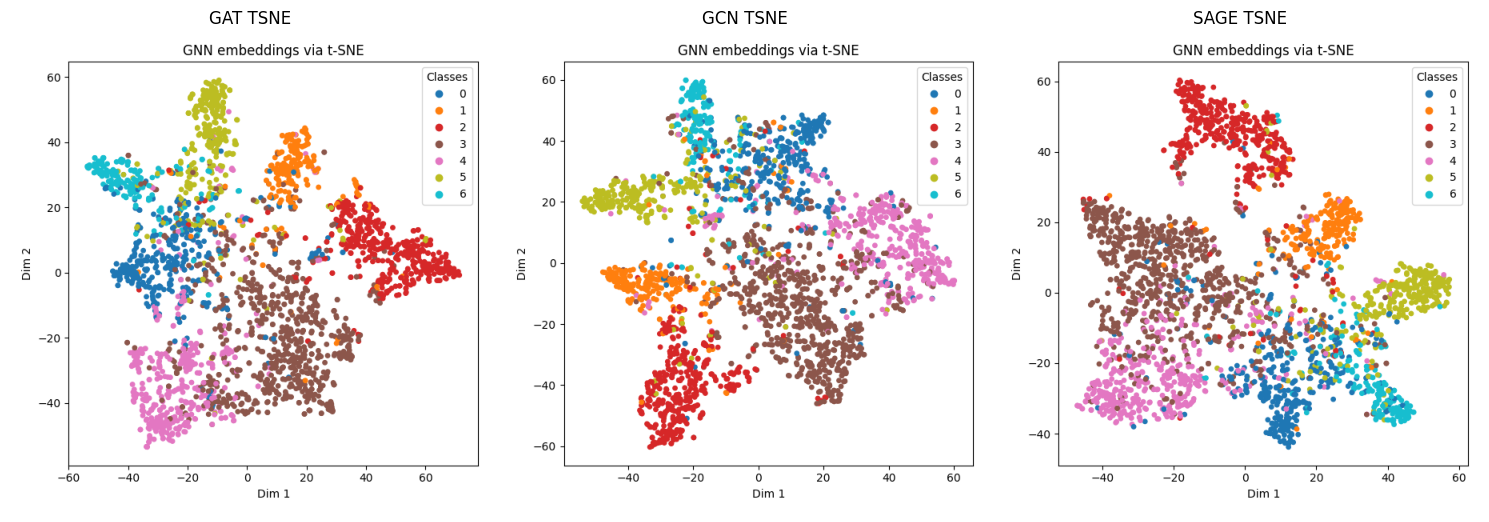

In [6]:
# Load pictures for figures/
figures_dir = Path("figures")
if figures_dir.exists():
    figures = [f for f in figures_dir.glob("*.png")]
else:
    figures = []

# Display figures
import matplotlib.pyplot as plt
def display_figures(figures):
    fig, axs = plt.subplots(1, len(figures), figsize=(15, 10))
    for ax, fig_path in zip(axs, figures):
        img = plt.imread(fig_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(fig_path.stem.replace('_', ' ').title().upper())
    plt.tight_layout()
    plt.show()

if figures:
    display_figures(figures)

## Confusion Matrices

Per-class errors on the test split for each GNN.


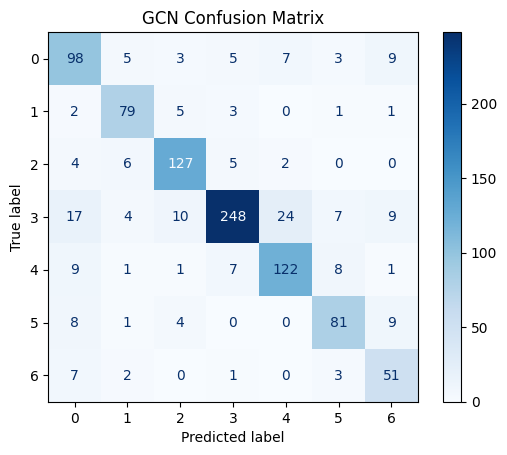

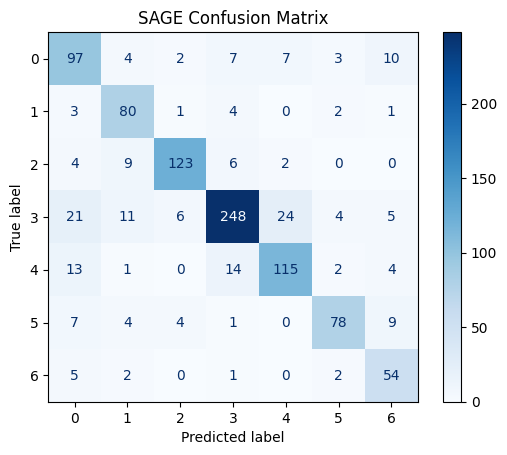

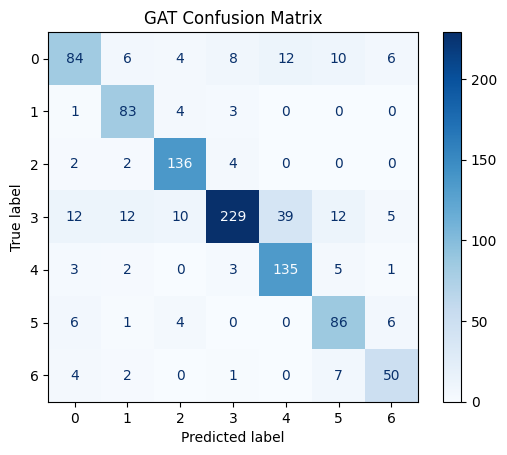

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.train import Net

models = [("GCN","checkpoints/gcn.pt"),("SAGE","checkpoints/sage.pt"),("GAT","checkpoints/gat.pt")]
for name, ckpt in models:
    net = Net(
        data.num_node_features, cfg["model"]["hidden_size"],
        data.num_classes, cfg["model"]["dropout"],
        model=name.lower(), gat_heads=cfg["model"]["gat_heads"]
    )
    net.load_state_dict(torch.load(ckpt)); net.eval()
    logits = net(data).cpu().detach().numpy()
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = logits[data.test_mask.cpu().numpy()].argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

## Cluster Purity

We cluster the hidden embeddings into _C_ groups (via K-means) where _C_ = number of classes, then compute purity:  

$$
\frac{1}{N}\sum_k \max_j \lvert\text{points in cluster }k \cap \text{class }j\rvert
$$


In [8]:
from sklearn.cluster import KMeans

for name, ckpt in models:
    net = Net(
        data.num_node_features, cfg["model"]["hidden_size"],
        data.num_classes, cfg["model"]["dropout"],
        model=name.lower(), gat_heads=cfg["model"]["gat_heads"]
    )
    net.load_state_dict(torch.load(ckpt)); net.eval()
    emb = net.conv1(data.x, data.edge_index).detach().cpu().numpy()
    km = KMeans(n_clusters=data.num_classes, random_state=42).fit(emb)
    labels = km.labels_; y = data.y.cpu().numpy()
    purity = sum(np.bincount(y[labels==i]).max() for i in range(data.num_classes)) / len(y)
    print(f"{name} cluster purity: {purity:.4f}")


GCN cluster purity: 0.7005
SAGE cluster purity: 0.7581
GAT cluster purity: 0.7426


## Misclassified Nodes

Examine a few test-set nodes where model predictions differ from true labels.


In [15]:
# Misclassified nodes
misclassified_nodes = []
for name, ckpt in models:
    net = Net(
        data.num_node_features, cfg["model"]["hidden_size"],
        data.num_classes, cfg["model"]["dropout"],
        model=name.lower(), gat_heads=cfg["model"]["gat_heads"]
    )
    net.load_state_dict(torch.load(ckpt)); net.eval()

    mask = data.test_mask.cpu().numpy()
    y_true = data.y[mask].cpu().numpy()
    y_pred = net(data).argmax(dim=1)[mask].cpu().numpy()
    mis = np.where(y_true != y_pred)[0]

    for node in mis:
        misclassified_nodes.append({
            "Model": name,
            "Node ID": node.item(),
            "True Label": y_true[node],
            "Predicted Label": y_pred[node]
        })

misclassified_df = pd.DataFrame(misclassified_nodes)

# Display few misclassified nodes
print(misclassified_df.sample(5).to_string(index=False))

# Check number of misclassified nodes per model
misclassified_counts = misclassified_df.groupby("Model").size().reset_index(name='Misclassified Count')
print()
print(misclassified_counts)

Model  Node ID  True Label  Predicted Label
  GCN      640           3                4
 SAGE      893           3                1
  GAT      465           6                1
 SAGE       56           5                2
  GCN      961           3                0

  Model  Misclassified Count
0   GAT                  197
1   GCN                  194
2  SAGE                  205


## Conclusion & Reproducibility

- **GCN** achieved the highest test accuracy (0.8059) while also having the shortest average epoch time and the smallest memory footprint—likely because Cora is a small graph.  

- **GraphSAGE** ran about 3× slower per epoch than GCN. It also reached the highest cluster purity but produced the most misclassified nodes (margins were small).  

- **GAT** consumed roughly 1.5× more memory than GCN, with accuracy between that of GCN and GraphSAGE.  

- **Baseline (Logistic Regression)** scored only ~50% test accuracy, far below the ~80% achieved by all GNN models.  


- **Insights**:  
  - On small citation graphs, simpler architectures like GCN can be both faster and more accurate.  
  - GraphSAGE’s stronger clustering comes at the cost of higher runtime and slightly more errors, while GAT balances accuracy with attention-based expressivity but uses more memory.  
  - These distinctions are likely to become more pronounced on larger, more complex graphs.  

  
- **Reproducibility**:  
  1. Clone the repo and install dependencies:  
     ```bash
     pip install -r requirements.txt
     ```  
  2. Train each model:  
     ```bash
     python train.py --model gcn
     python train.py --model sage
     python train.py --model gat
     ```  
  3. Launch MLflow UI to compare runs:  
     ```bash
     mlflow ui --backend-store-uri mlruns
     ```  
  4. Run this notebook from top to bottom to reproduce all analyses.  
